Lecture 2 | Word Vector Representations: word2vec: https://www.youtube.com/watch?v=ERibwqs9p38

Notes:

Wordnet can be accesed through nltk, groups of synsets (groups of synonyms) 

from ntltk.corpus import wordnet as wn
panda = wn.sysnet('panda.n.01')
hyper = lambda s: s.hypernyms()
list(panda.closure(hyper))

Hard in practice, hard to compute accurate word similarity, missing slang.

Old models, each word is nation to itself, does not capture relationship, think words as one hot vectors considered as localist representation (dot product similarity).

Distributional similarity:
Looking at context in which word appears, i.e look at all sentences with banking, look at all context in which it appears.

For each word, come up with dense vector so that it is good a predicting other words that appear in context of this word. look at dot product between these word vectors. alter vector based on dot product (recursive).

Word Embedding and Neural Model:
p(context|words) = 
loss function = 1 - p(everything except wt|wt)
change repsentation of words to minimize loss

Main idea of word2vec:
Predict between every word and its context words.

1. skip grams(SG) - predict context words given target(position independent)

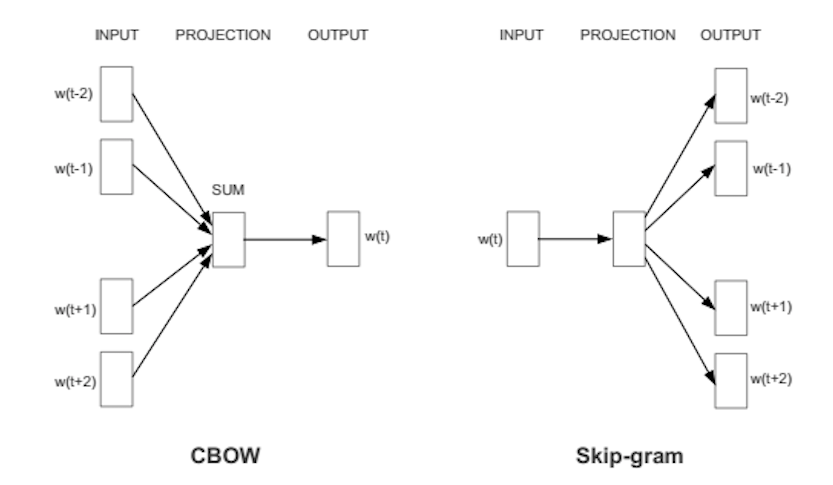

2. Coninuous Bag of Words(CBOW) - predict target word from bag-of-words context

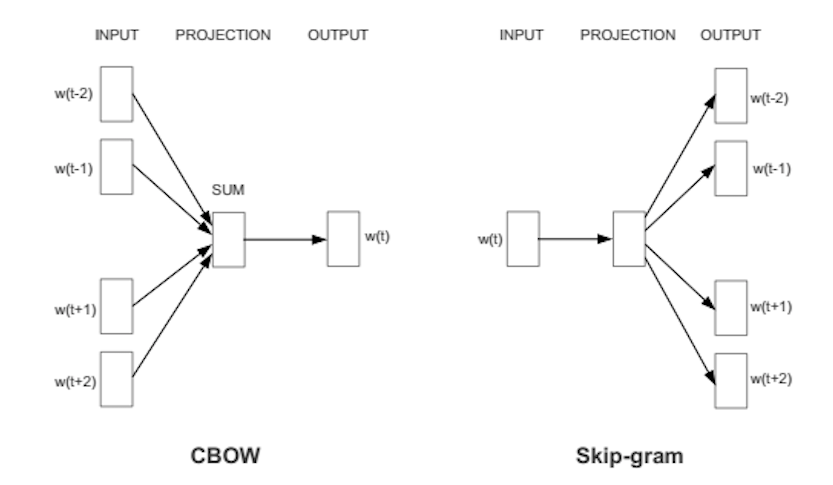

In [5]:
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import string
import logging
import random
import matplotlib.pyplot as plt


Using TensorFlow backend.


### Read and Format

In [8]:
df = pd.read_csv("train.csv")

In [10]:
df = df.dropna(subset=['comment_text'])

In [22]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [17]:
# Create an iterator object that returns words properly formatted for Word2Vec training
class W2VSentenceTokenizer:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–') #+ '\n'

    def __iter__(self):
        for row in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
            row = row.lower()
            for sentence in row.split('.')[:-1]:
                # Clean string of all punctuation
                sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words

In [18]:
sentences = W2VSetenceTokenizer(df[['comment_text']])

### Word2Vec Model

In [21]:
# Train Word2Vec model with gensim on the dataset
w2v_model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=10, workers=4)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [38]:
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# Some validation on the quality of the Word2Vec model
print(w2v_model.wv.most_similar('cool', topn=3))
print(w2v_model.wv.most_similar('losers', topn=3))
print(w2v_model.wv.most_similar('install', topn=3))
print(w2v_model.wv.most_similar('life', topn=3))
print(w2v_model.wv.most_similar('gay', topn=10))
print(w2v_model.wv.most_similar('black', topn=10))

Vocabulary Size: 74124 - Embedding Dim: 100
[('nice', 0.7032912969589233), ('cute', 0.65351402759552), ('scary', 0.6256025433540344)]
[('whiners', 0.7602884769439697), ('winners', 0.7509161233901978), ('crybabies', 0.7265477180480957)]
[('build', 0.7161859273910522), ('unlock', 0.7063601613044739), ('inspect', 0.6770405769348145)]
[('lives', 0.7261984348297119), ('lifestyle', 0.6485481262207031), ('happiness', 0.6278767585754395)]
[('lgbt', 0.7995699644088745), ('homosexual', 0.7891637086868286), ('heterosexual', 0.7819026708602905), ('samesex', 0.7553851008415222), ('lgbtq', 0.7397756576538086), ('hetero', 0.7378289699554443), ('samegender', 0.7081549167633057), ('transgender', 0.6975041627883911), ('gays', 0.6896294355392456), ('lesbians', 0.6821993589401245)]
[('hispanic', 0.7003339529037476), ('\n\nblack', 0.6997890472412109), ('latino', 0.6644403338432312), ('samoan', 0.6610382795333862), ('africanamerican', 0.6541216373443604), ('caucasian', 0.6503481268882751), ('“black', 0.6211

In [43]:
w2v_model["trevor"]

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.40415558,  0.29383183, -0.64958733,  1.6517379 ,  1.061202  ,
       -1.3146423 ,  2.4903123 ,  2.6054473 , -0.28037757, -2.7478776 ,
        0.12777789, -0.41535985, -0.06944779,  1.1882056 ,  1.0802801 ,
       -1.9920034 , -0.7418825 ,  0.509533  , -0.70275867, -0.74294776,
        1.8252633 ,  1.0195934 , -1.1843565 ,  2.1033027 , -0.53726137,
       -0.40440345,  0.8350719 ,  0.05664099,  0.6637031 , -0.01373372,
        1.1920686 ,  0.02168783, -2.702943  ,  0.42684713,  0.1947524 ,
       -0.8528302 ,  3.1636405 , -0.8022329 ,  0.45450798,  2.3777707 ,
       -1.3013995 , -0.46365723,  0.8115554 ,  1.7520837 ,  0.13575865,
       -0.13602994, -1.1119895 , -0.39614406,  1.8659611 ,  1.3287622 ,
       -1.0325028 ,  0.8613401 , -1.4319535 , -0.00758217,  0.90627974,
       -2.2733736 , -0.20753969, -2.1176403 , -1.2340451 ,  0.8782457 ,
        0.8556989 , -0.5921522 ,  1.1073822 ,  2.1074862 ,  0.27225852,
       -1.5813805 ,  0.1756825 , -0.89573514,  0.14425693,  0.48

In [31]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


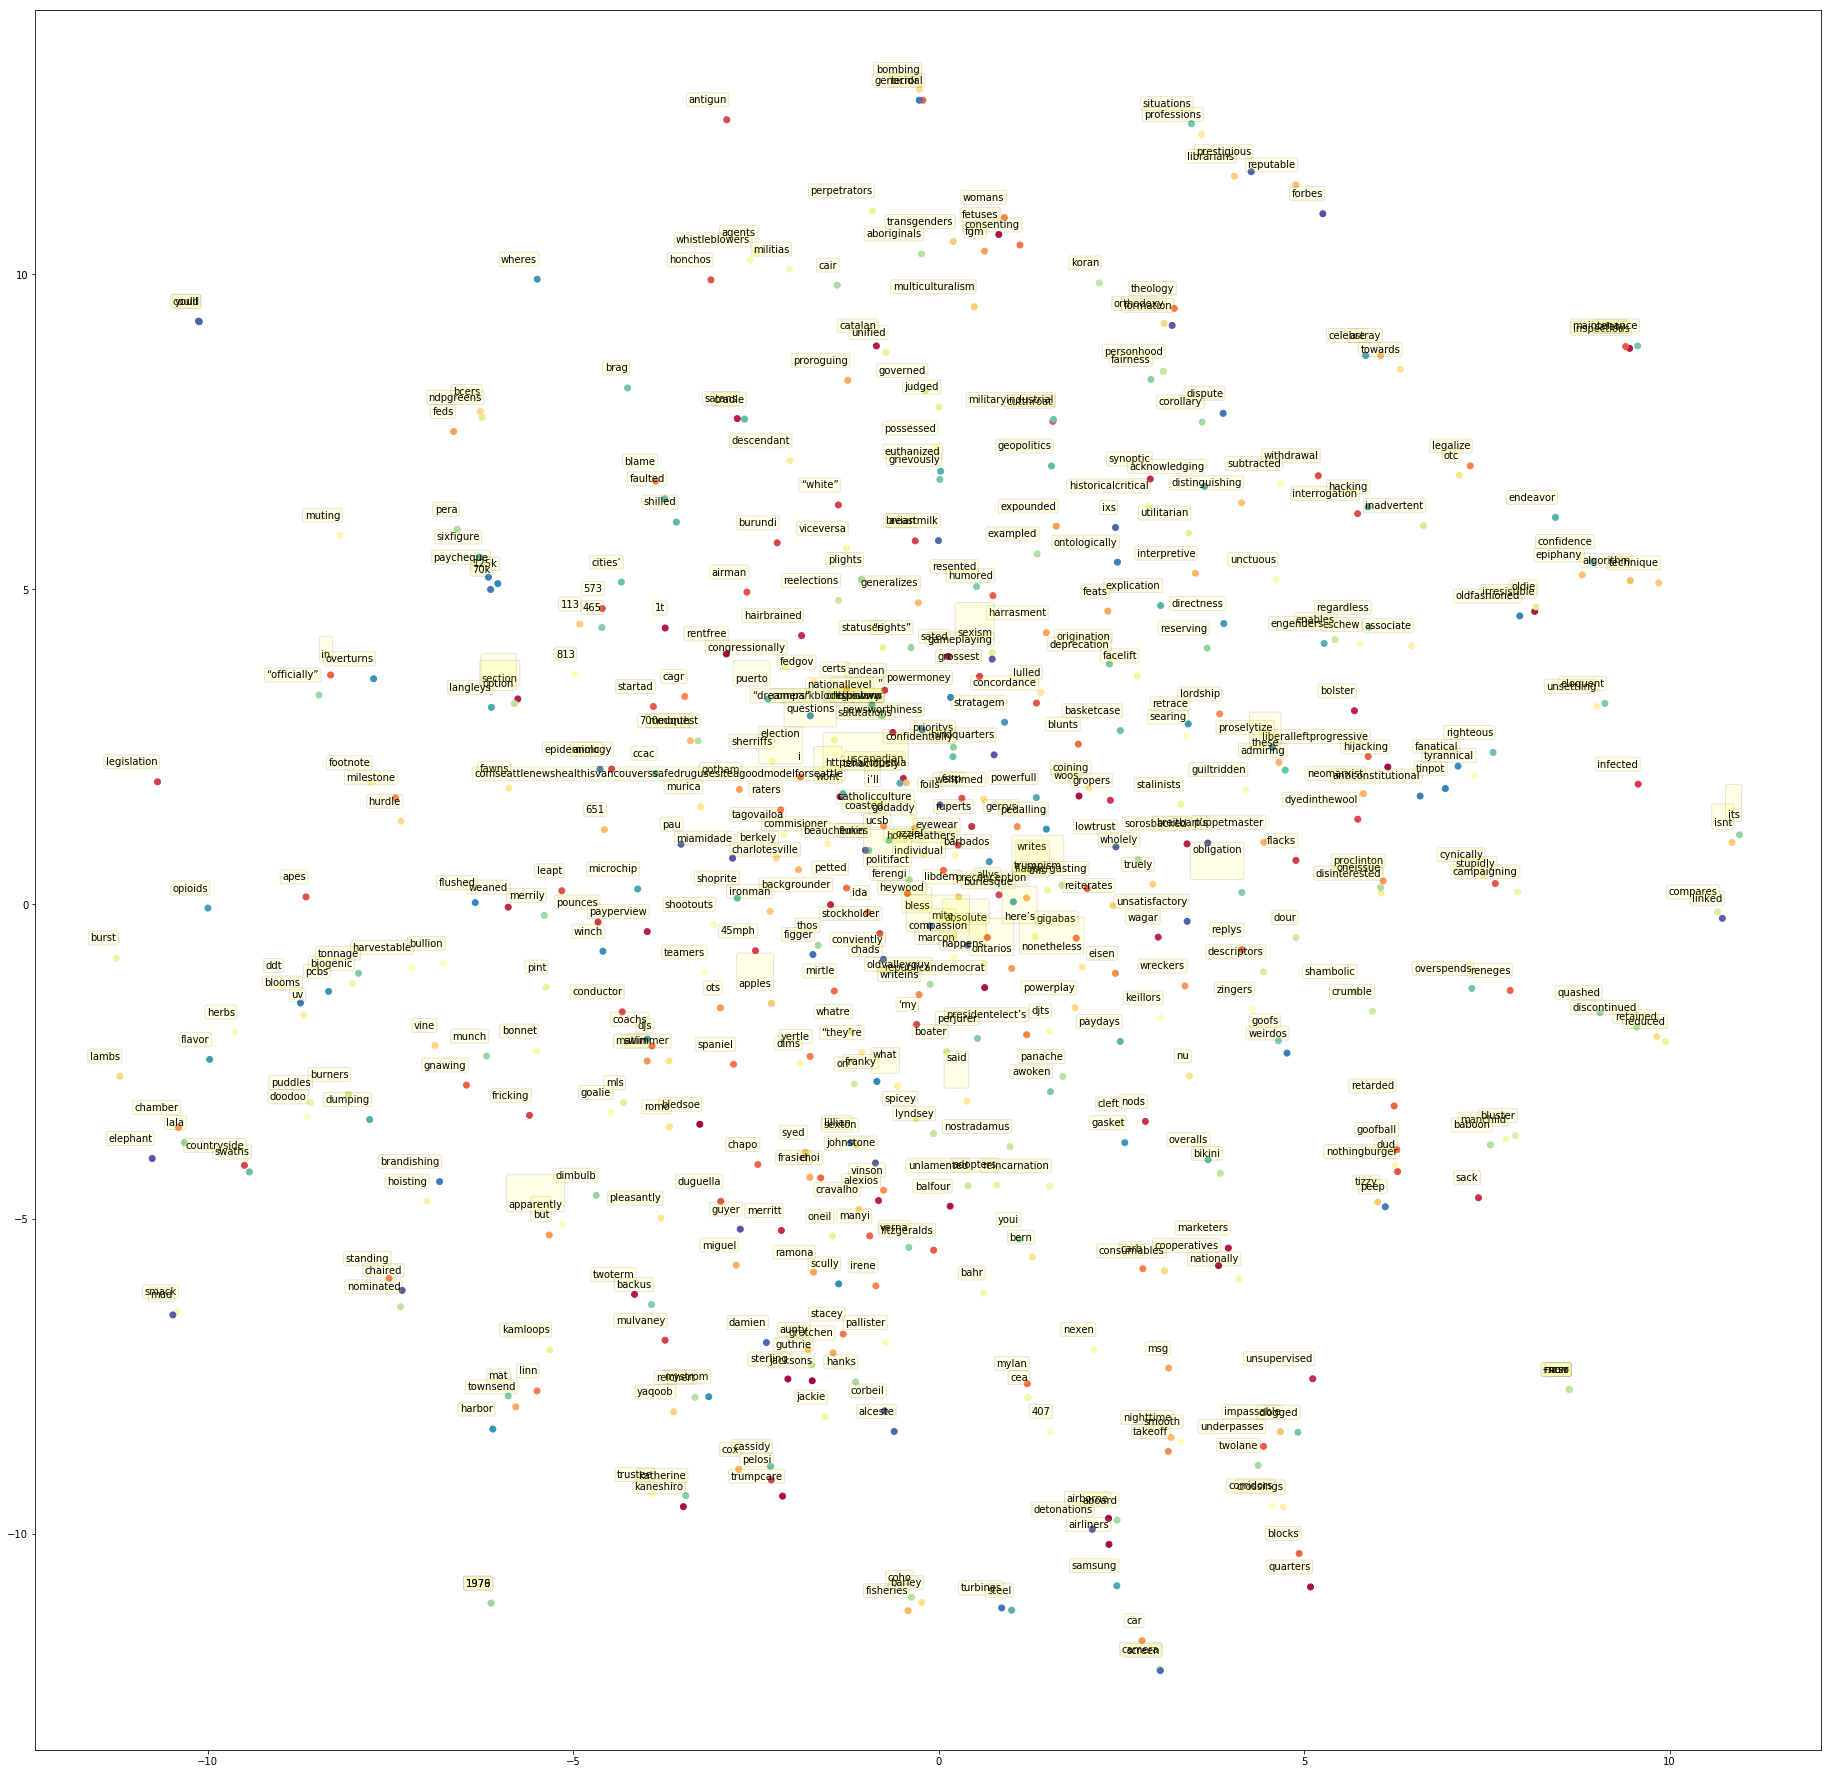

In [33]:
from sklearn.manifold import TSNE

n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([w2v_model[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))